<a href="https://colab.research.google.com/github/Nram94/simulacion-modelacion-python/blob/main/Semana04_ModelosFenomenologicos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 💧 Ejercicio: Enfriamiento Dinámico de Bálsamo Labial Viscoso

## Escenario: Enfriamiento de Bálsamo Labial en un Tanque Agitado

Una base de bálsamo labial fundida (fluido no newtoniano) está a $T_0 = 85^{\circ}C$ en un tanque agitado continuo (CSTR).  

Para solidificar el producto, se abre una línea de agua de enfriamiento que mantiene la chaqueta del reactor a $ T_j = 25^{\circ}C. $

---

El reto es que la **viscosidad** $ \mu $ del bálsamo aumenta drásticamente a medida que se enfría,  
lo que a su vez **reduce la eficiencia de la agitación** y, por ende,  
el **coeficiente de transferencia de calor por convección** $ h $.

---

### 🎯 Objetivo

Construir el modelo fenomenológico dinámico para simular el perfil de temperatura $ T(t) $ del bálsamo hasta que alcanza $ 35^{\circ}C. $


# 🧾 Parámetros del Sistema

| Parámetro               | Símbolo       | Valor    | Unidades                         |
|--------------------------|---------------|----------|----------------------------------|
| Masa del Bálsamo         | **M**         | 100      | kg                               |
| Capacidad Calorífica     | **Cₚ**        | 3000     | J/kg·K                           |
| Área de Intercambio      | **A**         | 1.5      | m²                               |
| Coeficiente **h₀**       | **h₀**        | 500      | W/m²·K·(Pa·s)⁰·²                |
| Constante Viscosidad     | **E<sub>μ</sub>/R** | 3000     | K                                |
| Viscosidad de Referencia | **μ<sub>ref</sub>** | 0.5      | Pa·s                             |
| Temperatura de Ref.      | **T<sub>ref</sub>** | 330      | K (57 °C)                        |
| Temperatura de Chaqueta  | **T<sub>j</sub>**   | 298.15   | K (25 °C)                        |
| Condición Inicial        | **T(t = 0)**  | 358.15   | K (85 °C)                        |


## 🧠 Tareas

1. Definir una función Python que reciba $T$ y $t$,  
   y que implemente las tres ecuaciones anidadas para devolver $\frac{dT}{dt}.$

2. Resolver la EDO con `scipy.integrate.odeint` o `solve_ivp`.

3. Determinar el tiempo de enfriamiento para alcanzar $T = 308.15\ \text{K}\ (35^{\circ}C).$

4. Graficar $T$ vs $t$ y comentar cómo la viscosidad hace que la curva se **aplane** (enfriamiento más lento) a medida que $T$ disminuye.


El producto alcanza 35.00°C en 10.30 minutos.


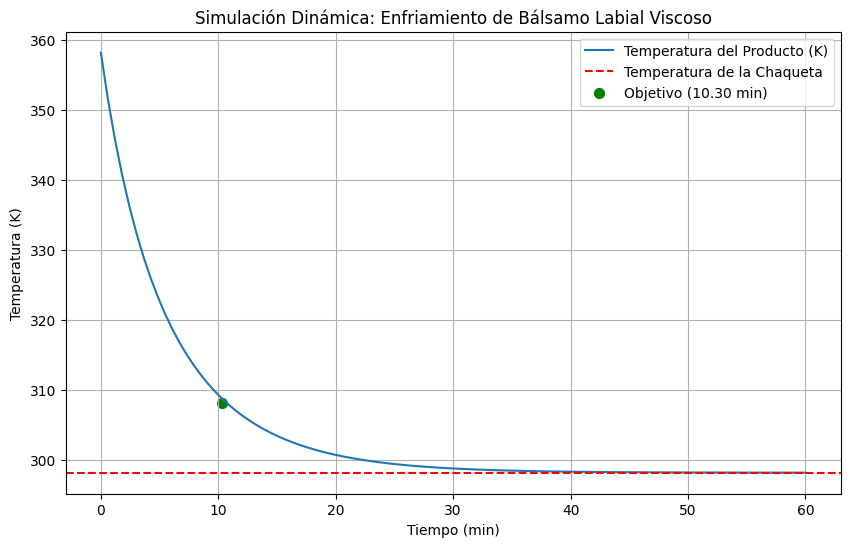

In [11]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import odeint


# =============================================================================
# 1. FUNCIÓN FENOMENOLÓGICA ACOPLADA (EDO de Balance de Energía)
#    Define dT/dt = f(T, t). Esta es la implementación de la EDO fundamental
#    con las ecuaciones constitutivas incrustadas.
# =============================================================================
def perfil_temperatura(T, t):
  # --- Parámetros Fijos del Sistema (Unidades SI) ---
  # M*Cp es el término de capacidad térmica (acumulación)
  M = 100 # Masa del producto [kg]
  Cp = 3000 # Capacidad calorífica [J/ kg K]
  A = 1.5 # Área de transferencia de calor [m2]
  T_ch = 298.15 # Temperatura de la chaqueta (absoluta) [K]

  # --- Parámetros de las Ecuaciones Constitutivas ---
  # Correlación de Transporte (Coeficiente h)
  h0 = 500 # Constante de la correlación h = h0 * mu^(-0.2) [W/m2 K (Pa s)^0.2]
  # Correlación de Propiedad (Viscosidad mu) - Tipo Arrhenius
  E_mu_R = 3000 # Constante de activación (E_mu/R) [K]
  mu_ref = 0.5 # Viscosidad de referencia [Pa s]
  T_ref = 330 # Temperatura de referencia [K]

  # =========================================================================
  # CÁLCULOS CONSTITUTIVOS (Implementación de Nivel 2)
  # =========================================================================

  # 1. ECUACIÓN CONSTITUTIVA de PROPIEDAD (Viscosidad mu)
  # Calcula la viscosidad (mu) en función de la temperatura (T).
  # La viscosidad aumenta fuertemente a medida que T disminuye.
  expo_interno = E_mu_R*((1/T) - (1/T_ref))
  exponencial = np.exp(expo_interno)
  mu = mu_ref * exponencial # Cierra el modelo de propiedad

  # 2. ECUACIÓN CONSTITUTIVA de TRANSPORTE (Coeficiente Convectivo h)
  # h = h0 * mu^(-0.2). El coeficiente de convección (h) disminuye si la viscosidad (mu) sube.
  termino_02 = mu**-0.2
  h = h0 * termino_02 # Cierra el modelo de transporte

  # 3. Balance de Energía (EDO Fundamental)
  # El flujo de calor es Q_dot = h * A * (T_ch - T).
  termino_parentesis = h # El coeficiente h es ahora la conductancia global UA (simplificado)
  diff_T = T_ch - T # Fuerza impulsora del enfriamiento

  # 4. Término de Acumulación (M*Cp)
  M_Cp = M * Cp # Capacidad de acumulación de calor del bálsamo

  # EDO: dT/dt = (1/Acumulación) * Tasa_Neta_Transferencia
  dT_dt = (A * termino_parentesis * diff_T) / M_Cp

  return dT_dt

# =============================================================================
# 2. SOLUCIÓN NUMÉRICA
# =============================================================================

# --- Condiciones Iniciales ---
T0 = 85 + 273.15 # Temperatura inicial del bálsamo (de °C a K)

# --- Definición de la Simulación ---
# Vector de tiempo (0 a 3600 segundos = 60 minutos)
t = np.linspace(0, 3600, 100)

# Integración de la EDO usando odeint
T_sol = odeint(
  perfil_temperatura, # La función que define dT/dt
  T0, # Condición inicial T(t=0)
  t # Puntos de tiempo para la solución
)

# --- Análisis del Tiempo Objetivo ---
T_obj = 35 + 273.15 # Temperatura objetivo (de 35°C a K)

# np.where(T_sol >= T_obj)[0] encuentra todos los índices donde T es mayor o igual al objetivo.
# [-1] selecciona el último de esos índices (el punto justo antes de caer por debajo, si está enfriando).
idx = np.where(T_sol >= T_obj)[0][-1]
t_obj_seg = t[idx] # Tiempo en segundos
t_obj_min = t_obj_seg / 60.0 # Conversión a minutos

# --- Resultados y Visualización ---
print(f"El producto alcanza {T_obj - 273.15:.2f}°C en {t_obj_min:.2f} minutos.") # Muestra T en °C
plt.figure(figsize=(10, 6))
# Se grafica el tiempo en minutos (t/60) y la temperatura en Kelvin
plt.plot(t/60, T_sol, label='Temperatura del Producto (K)')
T_ch_K = 25+273.15 # Temperatura de chaqueta en K para el gráfico
plt.axhline(T_ch_K, color='red', linestyle='--', label='Temperatura de la Chaqueta')
# Marca el punto objetivo en el gráfico
plt.scatter(t_obj_min, T_obj, color='green', s=50, label=f'Objetivo ({t_obj_min:.2f} min)')
plt.title("Simulación Dinámica: Enfriamiento de Bálsamo Labial Viscoso")
plt.xlabel("Tiempo (min)")
plt.ylabel("Temperatura (K)")
plt.legend()
plt.grid(True)
plt.show()